### Import Packages

In [1]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import optuna
import sklearn
import matplotlib as plt
import numpy as np
import category_encoders as ce
import joblib
import catboost as cb


#  version info dictionary
versions = {
    "Pandas": pd.__version__,
    "Seaborn": sns.__version__,
    "XGBoost": xgb.__version__,
    "Optuna": optuna.__version__,
    "Scikit-learn": sklearn.__version__,
    "NumPy": np.__version__,
    "Matplotlib": plt.__version__,
    "Category Encoders": ce.__version__,
    "Joblib": joblib.__version__,
    "CatBoost": cb.__version__,
}

# Print versions 
print("Package Versions:")
print("-" * 40)
for package, version in versions.items():
    print(f"{package:.<25} v{version}")
print("-" * 40)

Package Versions:
----------------------------------------
Pandas................... v2.2.2
Seaborn.................. v0.13.2
XGBoost.................. v2.1.1
Optuna................... v4.0.0
Scikit-learn............. v1.5.1
NumPy.................... v1.26.4
Matplotlib............... v3.9.2
Category Encoders........ v2.6.4
Joblib................... v1.4.2
CatBoost................. v1.2.7
----------------------------------------


### Data loading 

In this project, my task involves working with data from four USA airports. I have merged these datasets into a single dataset. Below is the dataset link. The merged dataset is over 1 GB, so it is saved on Google Drive.
Airport  names:

* DFW: Dallas/Fort Worth International Airport
* DTW: Detroit Metropolitan Wayne County Airport
* EWR: Newark Liberty International Airport
* IAD: Washington Dulles International Airport

**https://drive.google.com/drive/folders/1IbwWkGf3PpKzJGYgmOs6v7bsbu0Uf0mx?usp=drive_link**

In [3]:
pwd

'/Users/sadmansakib/Downloads/AdvanceML/adv_mla_at3/notebooks'

In [5]:
# Load the dataset
import pandas as pd
df = pd.read_csv('../data/raw/merged_itineraries.csv')
print("Initial Shape:", df.shape)

Initial Shape: (2938190, 23)


In [3]:
df.tail().T

,2938185,2938186,2938187,2938188,2938189
legId,e8d5756cbb547a66ee1da40e543c9ed5,24ff1bf75499fc50b4cdedb74f22bb1b,5156f55c8db99a4d47a74ba8dd2fa5a7,6ffb8c0e15b78e48492c15db53ca9e7e,6f5e1fcc325768bd2941a3f35e50ab4c
searchDate,2022-05-09,2022-05-09,2022-05-09,2022-05-09,2022-05-09
flightDate,2022-06-17,2022-06-17,2022-06-17,2022-06-17,2022-06-17
startingAirport,IAD,IAD,IAD,IAD,IAD
destinationAirport,SFO,SFO,SFO,SFO,SFO
travelDuration,PT7H53M,PT9H34M,PT5H43M,PT5H50M,PT5H42M
isBasicEconomy,False,False,False,False,False
isRefundable,False,False,False,False,False
isNonStop,False,False,True,True,True
totalFare,791.1,791.1,868.6,999.0,1128.6


In [4]:
print(df.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938190 entries, 0 to 2938189
Data columns (total 23 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   legId                              object 
 1   searchDate                         object 
 2   flightDate                         object 
 3   startingAirport                    object 
 4   destinationAirport                 object 
 5   travelDuration                     object 
 6   isBasicEconomy                     bool   
 7   isRefundable                       bool   
 8   isNonStop                          bool   
 9   totalFare                          float64
 10  totalTravelDistance                float64
 11  segmentsDepartureTimeEpochSeconds  object 
 12  segmentsDepartureTimeRaw           object 
 13  segmentsArrivalTimeEpochSeconds    object 
 14  segmentsArrivalTimeRaw             object 
 15  segmentsArrivalAirportCode         object 
 16  segmentsDepartureA

In [5]:
# Convert boolean columns to int64 (True -> 1, False -> 0)
df['isBasicEconomy'] = df['isBasicEconomy'].astype('int64')
df['isRefundable'] = df['isRefundable'].astype('int64')
df['isNonStop'] = df['isNonStop'].astype('int64')

In [6]:
print(df.describe()) 

       isBasicEconomy  isRefundable     isNonStop     totalFare  \
count    2.938190e+06  2.938190e+06  2.938190e+06  2.938190e+06   
mean     6.594604e-02  1.803832e-05  2.906422e-01  3.500359e+02   
std      2.481878e-01  4.247116e-03  4.540588e-01  1.819086e+02   
min      0.000000e+00  0.000000e+00  0.000000e+00  3.069000e+01   
25%      0.000000e+00  0.000000e+00  0.000000e+00  2.256000e+02   
50%      0.000000e+00  0.000000e+00  0.000000e+00  3.196000e+02   
75%      0.000000e+00  0.000000e+00  1.000000e+00  4.441000e+02   
max      1.000000e+00  1.000000e+00  1.000000e+00  7.548600e+03   

       totalTravelDistance  
count         2.659765e+06  
mean          1.364025e+03  
std           7.073600e+02  
min           9.700000e+01  
25%           8.180000e+02  
50%           1.298000e+03  
75%           1.702000e+03  
max           3.686000e+03  


### Data cleaning

**Check for Exact Duplicates Across All Columns**

In [7]:
# Check for exact duplicates across all columns
exact_duplicates = df[df.duplicated()]
print("Number of exact duplicate rows:", exact_duplicates.shape[0])

# Display a sample of exact duplicates, if any
if exact_duplicates.shape[0] > 0:
    print("Sample of exact duplicate rows:")
    print(exact_duplicates.head())
else:
    print("No exact duplicates found.")

Number of exact duplicate rows: 0
No exact duplicates found.


In [8]:
# Count the total number of duplicate rows based on 'legId'
total_duplicates = df.duplicated(subset='legId').sum()

# Calculate the percentage of duplicate rows
duplicate_percentage = (total_duplicates / len(df)) * 100

print("Total duplicate rows based on 'legId':", total_duplicates)
print("Percentage of duplicate rows:", duplicate_percentage, "%")

Total duplicate rows based on 'legId': 2568258
Percentage of duplicate rows: 87.40952763435993 %


In [3]:
import pandas as pd

#Identify duplicate legIds
duplicate_legids = df[df.duplicated(subset='legId', keep=False)]

#Sample 5 duplicate legIds
sample_legids = duplicate_legids['legId'].drop_duplicates().sample(5, random_state=1)

# Check travelDuration consistency for each sampled legId
for leg_id in sample_legids:
    leg_data = df[df['legId'] == leg_id]
    travel_durations = leg_data['travelDuration'].unique()
    print(f"LegId: {leg_id}")
    print(f"Unique travel durations for this LegId: {travel_durations}")
    print("Consistent travel duration across duplicates" if len(travel_durations) == 1 else "Different travel durations across duplicates")
    print("-" * 50)

LegId: 7125f98e72259013fe300969193e6417
Unique travel durations for this LegId: ['PT8H38M']
Consistent travel duration across duplicates
--------------------------------------------------
LegId: 3a51161632593e4f68c9a479a0485f03
Unique travel durations for this LegId: ['PT4H31M']
Consistent travel duration across duplicates
--------------------------------------------------
LegId: 7ce87f9e96ac459222f0ed151b23ebe1
Unique travel durations for this LegId: ['PT9H48M']
Consistent travel duration across duplicates
--------------------------------------------------
LegId: ed4416c95fc439db79d75eda7079bfea
Unique travel durations for this LegId: ['PT12H43M']
Consistent travel duration across duplicates
--------------------------------------------------
LegId: e2814bb0eb77b0551b390993bba171a3
Unique travel durations for this LegId: ['PT9H19M']
Consistent travel duration across duplicates
--------------------------------------------------


In [11]:
# Check for duplicates based on 'legId' and 'flightDate'
duplicate_legid_flightdate = df[df.duplicated(subset=['legId', 'flightDate'], keep=False)]
print("Number of duplicates based on 'legId' and 'flightDate':", duplicate_legid_flightdate.shape[0])

# Display a sample of rows with duplicate 'legId' and 'flightDate' for inspection
if duplicate_legid_flightdate.shape[0] > 0:
    print("Sample of duplicates based on 'legId' and 'flightDate':")
    print(duplicate_legid_flightdate.head())
else:
    print("No duplicates based on 'legId' and 'flightDate'.")

Number of duplicates based on 'legId' and 'flightDate': 2849202
Sample of duplicates based on 'legId' and 'flightDate':
                              legId  searchDate  flightDate startingAirport  \
0  5db2f9ca9401fcafd601c699eec6c9dc  2022-04-19  2022-05-21             DFW   
1  1d1d1df31936643921f62bb7e17c41b5  2022-04-19  2022-05-21             DFW   
2  2a44a4b90de67adeeb9d5f2d2169a3ef  2022-04-19  2022-05-21             DFW   
3  8357772132251b9c07bc5a1bc76b52ce  2022-04-19  2022-05-21             DFW   
4  e300325495de1f8202dc5dff3b20d012  2022-04-19  2022-05-21             DFW   

  destinationAirport travelDuration  isBasicEconomy  isRefundable  isNonStop  \
0                ATL         PT2H8M               0             0          1   
1                ATL        PT2H15M               0             0          1   
2                ATL         PT2H4M               1             0          1   
3                ATL         PT2H5M               1             0          1   
4    

**Keep Only the Most Recent Record for Each legId and flightDate**

In [12]:
# Sort by 'searchDate' in descending order so the most recent record appears first
df = df.sort_values(by='searchDate', ascending=False)

# Drop duplicates based on 'legId' and 'flightDate', keeping only the most recent record
df = df.drop_duplicates(subset=['legId', 'flightDate'], keep='first')
print("Shape after keeping only the most recent search record per 'legId' and 'flightDate':", df.shape)

Shape after keeping only the most recent search record per 'legId' and 'flightDate': (369932, 23)


In [13]:
# Count the number of unique legId values
num_unique_legids = df['legId'].nunique()
print("Number of unique legId values:", num_unique_legids)

Number of unique legId values: 369932


In [14]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])


Missing values in each column:
totalTravelDistance             31465
segmentsEquipmentDescription     3560
segmentsDistance                 3158
dtype: int64


**totalTravelDistance**

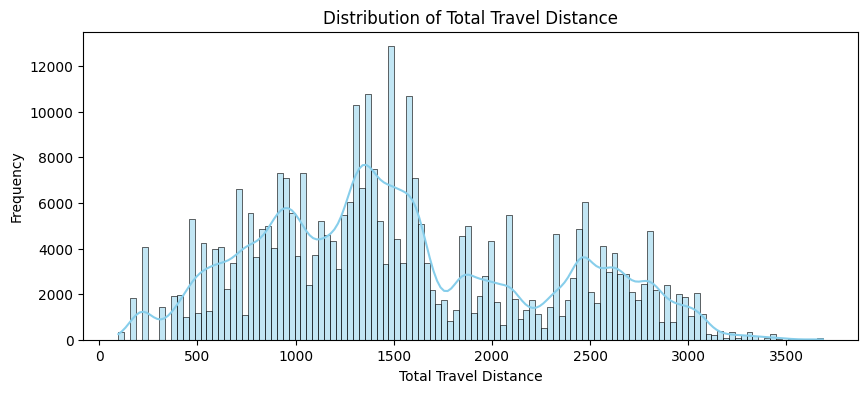

In [15]:
# Visualize missing values in totalTravelDistance
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new figure
fig = plt.figure(figsize=(10, 4))

# Create the histogram with a kernel density estimate
sns.histplot(data=df['totalTravelDistance'], kde=True, color="skyblue")

# Set the title and labels
plt.title("Distribution of Total Travel Distance")
plt.xlabel("Total Travel Distance")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [16]:
# Basic statistical summary
basic_stats = df['totalTravelDistance'].describe()
print("Basic Statistics for totalTravelDistance:")
print(basic_stats)

Basic Statistics for totalTravelDistance:
count    338467.000000
mean       1533.267223
std         723.358214
min          97.000000
25%         982.000000
50%        1399.000000
75%        2030.000000
max        3686.000000
Name: totalTravelDistance, dtype: float64


**Looking at the data visualization and statistics, I filled in the missing values with the median**

In [17]:
# Fill missing values in totalTravelDistance with the median
df['totalTravelDistance'] = df['totalTravelDistance'].fillna(df['totalTravelDistance'].median())

In [18]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
segmentsEquipmentDescription    3560
segmentsDistance                3158
dtype: int64


**converting the travel duration in minutes**

In [19]:
import re

# Function to parse ISO duration format (PT#H#M) to total minutes
def parse_duration(duration):
    # Handle missing values
    if pd.isna(duration):
        return np.nan
    # Use regex to match the pattern
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', duration)
    if not match:
        return np.nan  # Return NaN if the pattern does not match
    # Extract hours and minutes; set to 0 if they are missing
    hours = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    # Return total duration in minutes
    return hours * 60 + minutes

# Apply the function to the travelDuration column
df['travelDuration'] = df['travelDuration'].apply(parse_duration)

In [20]:
# Display a sample of the transformed travelDuration in minute 
print(df[['travelDuration']].head())

         travelDuration
1799870           637.0
221338            127.0
221326            475.0
221327            332.0
221328            403.0


In [21]:
# Convert 'searchDate' and 'flightDate' to datetime objects
df['searchDate'] = pd.to_datetime(df['searchDate'])
df['flightDate'] = pd.to_datetime(df['flightDate'])


In [22]:
# Extract date features from 'flightDate'
df['month'] = df['flightDate'].dt.month
df['day'] = df['flightDate'].dt.day
df['day_of_week'] = df['flightDate'].dt.dayofweek  # Monday=0, Sunday=6
df['week_of_year'] = df['flightDate'].dt.isocalendar().week


In [23]:
# Calculate 'date_diff' as the difference in days between 'flightDate' and 'searchDate'
df['date_diff'] = (df['flightDate'] - df['searchDate']).dt.days


In [24]:
import numpy as np

# Define a function to extract hour and minute from the first departure time
def extract_departure_time(row):
    if pd.notnull(row['segmentsDepartureTimeRaw']):
        first_departure = row['segmentsDepartureTimeRaw'].split('||')[0]
        # Remove milliseconds and timezone information 
        first_departure = first_departure.split('.')[0]
        try:
            departure_time = pd.to_datetime(first_departure)
            return pd.Series([departure_time.hour, departure_time.minute])
        except ValueError:
            # Handle any parsing errors
            return pd.Series([np.nan, np.nan])
    else:
        return pd.Series([np.nan, np.nan])

# Apply the function to extract 'hour' and 'minute'
df[['hour', 'minute']] = df.apply(extract_departure_time, axis=1)


In [25]:
df.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,travelDuration,isBasicEconomy,isRefundable,isNonStop,totalFare,...,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode,month,day,day_of_week,week_of_year,date_diff,hour,minute
1799870,230072de9338321ca5b68308a5010902,2022-05-19,2022-05-23,EWR,SFO,637.0,0,0,0,667.60,...,14580||13800,1380||1468,coach||coach,5,23,0,21,4,8,15
221338,49045917b782a566f75e5323ba5e85ee,2022-05-19,2022-05-28,DFW,ATL,127.0,0,0,1,202.60,...,7620,725,coach,5,28,5,21,9,14,25
221326,469a9a46f134f53c298a46be94696845,2022-05-19,2022-05-27,DFW,SFO,475.0,0,0,0,704.60,...,15420||8100,1663||679,coach||coach,5,27,4,21,8,6,15
221327,685fdabb3b9e0a0cea8f1042c7a21240,2022-05-19,2022-05-27,DFW,SFO,332.0,0,0,0,721.60,...,7500||9720,650||954,coach||coach,5,27,4,21,8,11,40
221328,c0b4a39823641254f5c05cc6704d39ce,2022-05-19,2022-05-28,DFW,ATL,403.0,0,0,0,122.98,...,8220||10440,650||1207,coach||coach,5,28,5,21,9,22,7


In [26]:
print(df.info()) 


<class 'pandas.core.frame.DataFrame'>
Index: 369932 entries, 1799870 to 2833400
Data columns (total 30 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   legId                              369932 non-null  object        
 1   searchDate                         369932 non-null  datetime64[ns]
 2   flightDate                         369932 non-null  datetime64[ns]
 3   startingAirport                    369932 non-null  object        
 4   destinationAirport                 369932 non-null  object        
 5   travelDuration                     369671 non-null  float64       
 6   isBasicEconomy                     369932 non-null  int64         
 7   isRefundable                       369932 non-null  int64         
 8   isNonStop                          369932 non-null  int64         
 9   totalFare                          369932 non-null  float64       
 10  totalTravelDistanc

In [27]:
print("Number of unique values:", df['segmentsCabinCode'].nunique())
print("\nAll unique values:")
print(df['segmentsCabinCode'].unique())


Number of unique values: 39

All unique values:
['coach||coach' 'coach' 'coach||coach||coach' 'premium coach||coach'
 'coach||coach||coach||coach' 'premium coach||coach||coach'
 'premium coach||premium coach' 'first||coach' 'coach||first'
 'coach||business||coach' 'first||first' 'business'
 'coach||coach||coach||first' 'premium coach' 'first'
 'coach||coach||coach||premium coach' 'coach||coach||first'
 'coach||premium coach' 'first||coach||coach||coach' 'business||coach'
 'first||first||coach' 'coach||business' 'coach||coach||premium coach'
 'coach||premium coach||coach' 'coach||first||coach' 'first||coach||coach'
 'premium coach||premium coach||coach' 'business||business||coach'
 'coach||first||first' 'coach||coach||business'
 'coach||premium coach||premium coach' 'business||coach||coach'
 'first||first||first' 'premium coach||coach||coach||coach'
 'premium coach||first' 'first||coach||first' 'coach||business||first'
 'business||business' 'coach||business||business']


In [28]:
# Function to split cabin codes
def split_cabin_codes(cabin_code):
    if pd.isnull(cabin_code):
        return []
    else:
        return cabin_code.split('||')

# Apply the function to create a new column with cabin codes list
df['cabin_codes_list'] = df['segmentsCabinCode'].apply(split_cabin_codes)


In [29]:
# Function to assign cabin types to cabin_Leg1, cabin_Leg2, etc.
def assign_cabin_legs(cabin_list):
    # Initialize with 'no_stop'
    cabins = ['no_stop', 'no_stop', 'no_stop', 'no_stop']
    for i in range(min(len(cabin_list), 4)):
        cabins[i] = cabin_list[i].strip().lower()
    return pd.Series(cabins, index=['cabin_Leg1', 'cabin_Leg2', 'cabin_Leg3', 'cabin_Leg4'])

# Apply the function to create new columns
df[['cabin_Leg1', 'cabin_Leg2', 'cabin_Leg3', 'cabin_Leg4']] = df['cabin_codes_list'].apply(assign_cabin_legs)


In [30]:
# Define a mapping for standard cabin types
cabin_type_mapping = {
    'coach': 'coach',
    'premium coach': 'premium coach',
    'business': 'business',
    'first': 'first',
    'no_stop': 'no_stop',
    
}

# Function to standardize cabin types
def standardize_cabin_type(cabin):
    return cabin_type_mapping.get(cabin, 'coach')  

# Apply the mapping to each cabin leg column
for col in ['cabin_Leg1', 'cabin_Leg2', 'cabin_Leg3', 'cabin_Leg4']:
    df[col] = df[col].apply(standardize_cabin_type)


In [31]:
for col in ['cabin_Leg1', 'cabin_Leg2', 'cabin_Leg3', 'cabin_Leg4']:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts())



Unique values in cabin_Leg1:
cabin_Leg1
coach            365115
premium coach      2740
first              1896
business            181
Name: count, dtype: int64

Unique values in cabin_Leg2:
cabin_Leg2
coach            310707
no_stop           56968
first              1427
premium coach       768
business             62
Name: count, dtype: int64

Unique values in cabin_Leg3:
cabin_Leg3
no_stop          322055
coach             47612
first               205
premium coach        36
business             24
Name: count, dtype: int64

Unique values in cabin_Leg4:
cabin_Leg4
no_stop          368862
coach              1004
premium coach        48
first                18
Name: count, dtype: int64


In [32]:
df.head().T

,1799870,221338,221326,221327,221328
legId,230072de9338321ca5b68308a5010902,49045917b782a566f75e5323ba5e85ee,469a9a46f134f53c298a46be94696845,685fdabb3b9e0a0cea8f1042c7a21240,c0b4a39823641254f5c05cc6704d39ce
searchDate,2022-05-19 00:00:00,2022-05-19 00:00:00,2022-05-19 00:00:00,2022-05-19 00:00:00,2022-05-19 00:00:00
flightDate,2022-05-23 00:00:00,2022-05-28 00:00:00,2022-05-27 00:00:00,2022-05-27 00:00:00,2022-05-28 00:00:00
startingAirport,EWR,DFW,DFW,DFW,DFW
destinationAirport,SFO,ATL,SFO,SFO,ATL
travelDuration,637.0,127.0,475.0,332.0,403.0
isBasicEconomy,0,0,0,0,0
isRefundable,0,0,0,0,0
isNonStop,0,1,0,0,0
totalFare,667.6,202.6,704.6,721.6,122.98


In [33]:
df.drop(columns=['cabin_codes_list'], inplace=True)


In [34]:
print(df[['travelDuration']].head(10))


         travelDuration
1799870           637.0
221338            127.0
221326            475.0
221327            332.0
221328            403.0
221329            137.0
221330            125.0
221331            125.0
221332            127.0
221333            127.0


**All destinations of airports**

In [35]:
print("Unique starting airports:", df['startingAirport'].unique())
print("Unique destination airports:", df['destinationAirport'].unique())


Unique starting airports: ['EWR' 'DFW' 'DTW' 'IAD']
Unique destination airports: ['SFO' 'ATL' 'BOS' 'CLT' 'PHL' 'OAK' 'ORD' 'MIA' 'JFK' 'LAX' 'EWR' 'IAD'
 'LGA' 'DEN' 'DTW' 'DFW']


In [36]:
# Check for missing values
missing_travel_distance = df['totalTravelDistance'].isnull().sum()
print(f"Missing Travel_distance values: {missing_travel_distance}")

df = df.dropna(subset=['totalTravelDistance'])


Missing Travel_distance values: 0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369932 entries, 1799870 to 2833400
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   legId                              369932 non-null  object        
 1   searchDate                         369932 non-null  datetime64[ns]
 2   flightDate                         369932 non-null  datetime64[ns]
 3   startingAirport                    369932 non-null  object        
 4   destinationAirport                 369932 non-null  object        
 5   travelDuration                     369671 non-null  float64       
 6   isBasicEconomy                     369932 non-null  int64         
 7   isRefundable                       369932 non-null  int64         
 8   isNonStop                          369932 non-null  int64         
 9   totalFare                          369932 non-null  float64       
 10  totalTravelDistanc

In [38]:
missing_travel_duration = df['travelDuration'].isnull().sum()
print(f"Missing travelDuration values: {missing_travel_duration}")


Missing travelDuration values: 261


**only 261 values are missing that is less than .01% so we are removing those rows**

In [39]:
df = df.dropna(subset=['travelDuration'])


In [40]:
# Drop the column if it's not needed
df = df.drop(columns=['segmentsEquipmentDescription'])

In [41]:
df['isBasicEconomy'] = df['isBasicEconomy'].astype(int)


#### EXploring Target Feature 


Fare Distribution Analysis:

Basic Statistics:
Count: 369671.0
Mean: $418.93
Median: $377.21
Std Dev: $224.94
Min: $30.69
Max: $7548.60

Skewness: 2.891
Kurtosis: 21.305


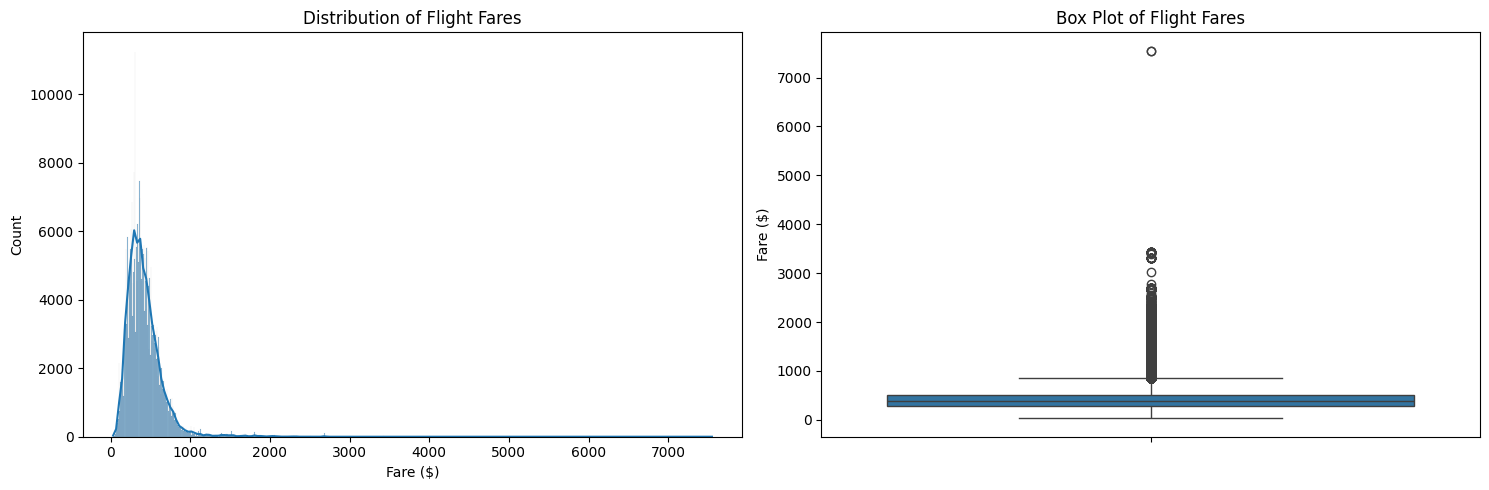

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_fare_distribution(df):
    """
    Analyze the distribution of flight fares
    """
    # Basic statistics
    fare_stats = df['totalFare'].describe()
    
    # Create subplot figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram with KDE
    sns.histplot(data=df, x='totalFare', kde=True, ax=ax1)
    ax1.set_title('Distribution of Flight Fares')
    ax1.set_xlabel('Fare ($)')
    ax1.set_ylabel('Count')
    
    # Box plot
    sns.boxplot(y=df['totalFare'], ax=ax2)
    ax2.set_title('Box Plot of Flight Fares')
    ax2.set_ylabel('Fare ($)')
    
    plt.tight_layout()
    
    # Calculate additional metrics
    skewness = df['totalFare'].skew()
    kurtosis = df['totalFare'].kurtosis()
    
    return {
        'basic_stats': fare_stats,
        'skewness': skewness,
        'kurtosis': kurtosis
    }

# Run the analysis
fare_results = analyze_fare_distribution(df)

print("\nFare Distribution Analysis:")
print("\nBasic Statistics:")
print(f"Count: {fare_results['basic_stats']['count']}")
print(f"Mean: ${fare_results['basic_stats']['mean']:.2f}")
print(f"Median: ${fare_results['basic_stats']['50%']:.2f}")
print(f"Std Dev: ${fare_results['basic_stats']['std']:.2f}")
print(f"Min: ${fare_results['basic_stats']['min']:.2f}")
print(f"Max: ${fare_results['basic_stats']['max']:.2f}")
print(f"\nSkewness: {fare_results['skewness']:.3f}")
print(f"Kurtosis: {fare_results['kurtosis']:.3f}")

**The fare price distribution is not bell-shaped, and some fares exceed the 75th percentile. This could be due to factors such as last-minute or emergency bookings**


Cabin Class Analysis:

Summary Statistics by Cabin Class:
                count     mean  median     std     min      max  percentage
cabin_Leg1                                                                 
business          181  1756.09  1499.0  798.49  509.00  3424.60        0.05
coach          364854   411.75   375.2  205.05   30.69  7548.60       98.70
first            1896  1355.46  1483.6  701.76  182.60  2690.20        0.51
premium coach    2740   637.83   582.6  255.11  258.60  1628.61        0.74

Percentage of flights with multiple legs:

cabin_Leg2 usage: 100.00%

cabin_Leg3 usage: 100.00%

cabin_Leg4 usage: 100.00%


<Figure size 1500x800 with 0 Axes>

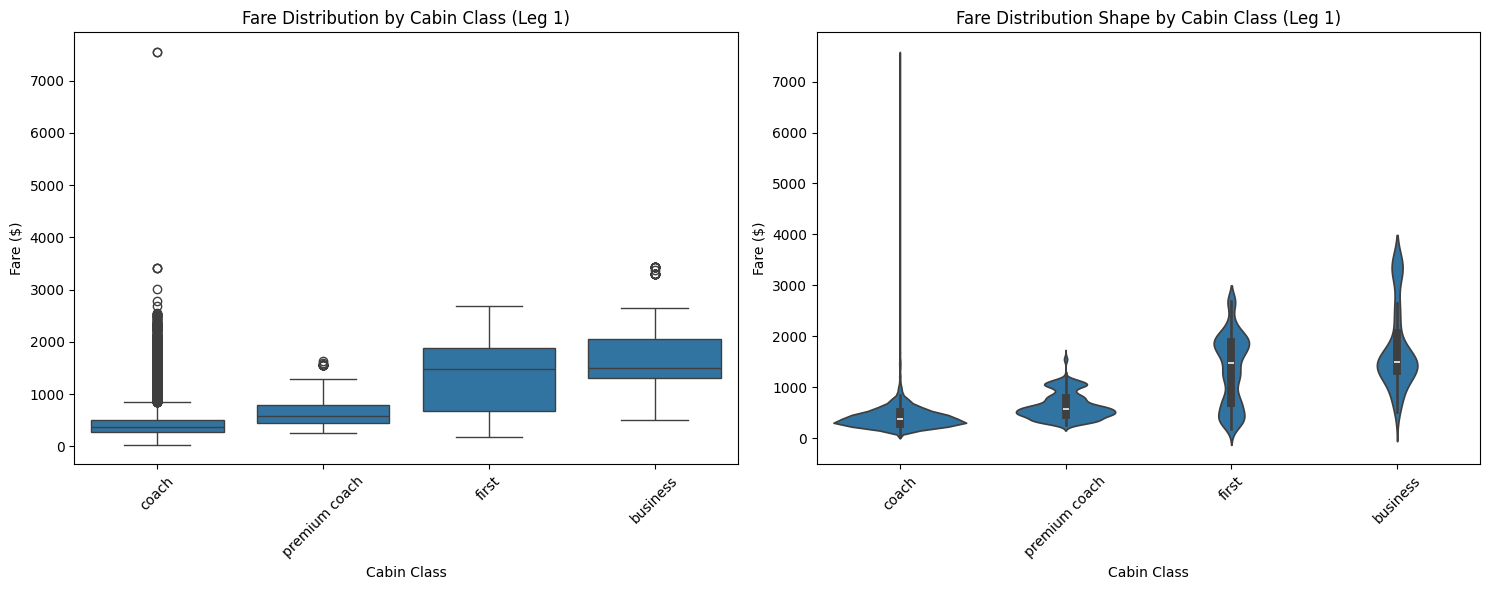

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_cabin_fares(df):
    """
    Analyze fare distribution across different cabin classes
    """
    plt.figure(figsize=(15, 8))
    
    # Create subplot figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot
    sns.boxplot(x='cabin_Leg1', y='totalFare', data=df, ax=ax1)
    ax1.set_title('Fare Distribution by Cabin Class (Leg 1)')
    ax1.set_xlabel('Cabin Class')
    ax1.set_ylabel('Fare ($)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Violin plot for detailed distribution
    sns.violinplot(x='cabin_Leg1', y='totalFare', data=df, ax=ax2)
    ax2.set_title('Fare Distribution Shape by Cabin Class (Leg 1)')
    ax2.set_xlabel('Cabin Class')
    ax2.set_ylabel('Fare ($)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    # Calculate summary statistics
    cabin_stats = df.groupby('cabin_Leg1')['totalFare'].agg([
        'count',
        'mean',
        'median',
        'std',
        'min',
        'max'
    ]).round(2)
    
    # Calculate percentage of total flights for each cabin class
    cabin_stats['percentage'] = (cabin_stats['count'] / len(df) * 100).round(2)
    
    return cabin_stats

# Run the analysis
cabin_results = analyze_cabin_fares(df)

print("\nCabin Class Analysis:")
print("\nSummary Statistics by Cabin Class:")
print(cabin_results)

# Additional analysis for subsequent legs if needed
subsequent_legs = ['cabin_Leg2', 'cabin_Leg3', 'cabin_Leg4']
non_empty_subsequent = df[subsequent_legs].nunique() > 1

print("\nPercentage of flights with multiple legs:")
for leg in subsequent_legs:
    non_empty = df[leg].nunique() > 1
    if non_empty:
        print(f"\n{leg} usage: {(df[leg].notna().sum() / len(df) * 100):.2f}%")

**From this visualization, we can see that the number of coach seats sold is higher than premium coach and first class. As mentioned in the previous figure, last-minute bookings could be a factor, and some coach seats were sold for over 7000, which are likely outliers since they exceed typical business class fares. Therefore, we are removing fares above 4,000 to better capture the pattern of last-minute bookings.**

In [45]:
# Remove rows with fares above $4000
original_len = len(df)

# Remove rows with fares above $4000 
df = df[df['totalFare'] <= 4000]

**Airline-wise Price Analysis and Statistics**

In [46]:
# Calculate average fares by airline and sort by mean fare
def categorize_airline(airline_name):
    if '||' in airline_name:
        return 'Combined Carriers'
    return airline_name

# Add a new column for airline category
df['airline_category'] = df['segmentsAirlineName'].apply(categorize_airline)

# Analyze single carriers first
single_carrier_stats = df[df['airline_category'] != 'Combined Carriers'].groupby('segmentsAirlineName')['totalFare'].agg([
    'count',
    'mean',
    'median',
    'std'
]).round(2)

# Add percentage of flights
single_carrier_stats['percentage'] = (single_carrier_stats['count'] / len(df) * 100).round(2)
single_carrier_stats = single_carrier_stats.sort_values('mean', ascending=False)

print("Single Carrier Statistics:")
print(single_carrier_stats)

# Now analyze combined carriers as a group
combined_stats = df[df['airline_category'] == 'Combined Carriers'].agg({
    'totalFare': ['count', 'mean', 'median', 'std']
}).round(2)

print("\nCombined Carriers Summary:")
print(f"Number of flights: {combined_stats['totalFare']['count']}")
print(f"Average fare: ${combined_stats['totalFare']['mean']}")
print(f"Median fare: ${combined_stats['totalFare']['median']}")
print(f"Percentage of total flights: {(combined_stats['totalFare']['count']/len(df)*100):.2f}%")

# Calculate price ranges for single carriers
print("\nPrice Ranges for Single Carriers:")
price_ranges = df[df['airline_category'] != 'Combined Carriers'].groupby('segmentsAirlineName')['totalFare'].agg([
    'min', 
    'max'
]).round(2)
print(price_ranges.sort_values('max', ascending=False))

Single Carrier Statistics:
                     count    mean  median     std  percentage
segmentsAirlineName                                           
Alaska Airlines        893  491.23  428.60  250.47        0.24
American Airlines    16285  341.91  296.61  235.24        4.41
United               18581  329.39  248.60  272.95        5.03
Delta                12220  308.64  278.60  142.66        3.31
JetBlue Airways       5772  259.86  236.60  139.72        1.56
Frontier Airlines      728  180.36  169.48   82.03        0.20
Spirit Airlines       2489  174.85  167.59   78.67        0.67

Combined Carriers Summary:
Number of flights: 312701.0
Average fare: $437.75
Median fare: $398.21
Percentage of total flights: 84.59%

Price Ranges for Single Carriers:
                        min      max
segmentsAirlineName                 
United                38.61  3424.60
American Airlines     68.60  2258.60
JetBlue Airways       38.61  1773.60
Delta                 54.60  1534.60
Alaska Airline

**From the statistical analysis, combined carriers make up most of the flights (84.59%) with an average fare of 437.75. Single carriers, like United Airlines and American Airlines, have a smaller market share but show a wide range of fares. United Airlines reaches the highest fare of 3425 and no other company’s flight fare exceeds 2500. Single carriers also display significant variability in pricing, with different mean fares and price ranges, suggesting varied strategies to target different customer segments.**

In [47]:
# Remove the temporarily created column
df.drop('airline_category', axis=1, inplace=True)

# Verify the column is removed
print("Current columns in dataframe:")
print(df.columns.tolist())

Current columns in dataframe:
['legId', 'searchDate', 'flightDate', 'startingAirport', 'destinationAirport', 'travelDuration', 'isBasicEconomy', 'isRefundable', 'isNonStop', 'totalFare', 'totalTravelDistance', 'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsDurationInSeconds', 'segmentsDistance', 'segmentsCabinCode', 'month', 'day', 'day_of_week', 'week_of_year', 'date_diff', 'hour', 'minute', 'cabin_Leg1', 'cabin_Leg2', 'cabin_Leg3', 'cabin_Leg4']


**Ticket Fare Analysis by Day and Month**

In [48]:
def analyze_fares_by_time(df):
    """
    Analyze flight fares by month and day with bar graphs
    """
    # Monthly analysis
    monthly_stats = pd.DataFrame()
    monthly_stats['mean_fare'] = df.groupby('month')['totalFare'].mean().round(2)
    monthly_stats['median_fare'] = df.groupby('month')['totalFare'].median().round(2)
    monthly_stats['min_fare'] = df.groupby('month')['totalFare'].min().round(2)
    monthly_stats['max_fare'] = df.groupby('month')['totalFare'].max().round(2)
    monthly_stats['fare_count'] = df.groupby('month')['totalFare'].count()
    
    # Daily analysis
    daily_stats = pd.DataFrame()
    daily_stats['mean_fare'] = df.groupby('day_of_week')['totalFare'].mean().round(2)
    daily_stats['median_fare'] = df.groupby('day_of_week')['totalFare'].median().round(2)
    daily_stats['min_fare'] = df.groupby('day_of_week')['totalFare'].min().round(2)
    daily_stats['max_fare'] = df.groupby('day_of_week')['totalFare'].max().round(2)
    daily_stats['fare_count'] = df.groupby('day_of_week')['totalFare'].count()
    
    # Create bar plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Monthly average fares
    monthly_stats['mean_fare'].plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Average Fare by Month')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average Fare ($)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Daily average fares
    daily_stats['mean_fare'].plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('Average Fare by Day of Week')
    ax2.set_xlabel('Day of Week (0=Monday)')
    ax2.set_ylabel('Average Fare ($)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    # Add day names
    days = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }
    daily_stats['day_name'] = [days[i] for i in daily_stats.index]
    
    return {
        'monthly_stats': monthly_stats,
        'daily_stats': daily_stats
    }

Monthly Fare Analysis:
       mean_fare  median_fare  min_fare  max_fare  fare_count
month                                                        
4         395.25       348.60     82.60   3384.61       42921
5         430.06       386.21     30.69   3424.60      145935
6         423.46       388.60     30.69   3424.60      136583
7         390.82       363.60     54.60   2684.60       44230

Daily Fare Analysis:
             mean_fare  median_fare  min_fare  max_fare  fare_count   day_name
day_of_week                                                                   
0               421.39       379.20     38.61   3424.60       54372     Monday
1               369.26       332.20     30.69   3424.60       55015    Tuesday
2               385.15       351.60     30.69   3424.60       54168  Wednesday
3               429.31       396.68     42.79   3424.60       54240   Thursday
4               437.62       405.85     42.79   3424.60       53972     Friday
5               401.83       3

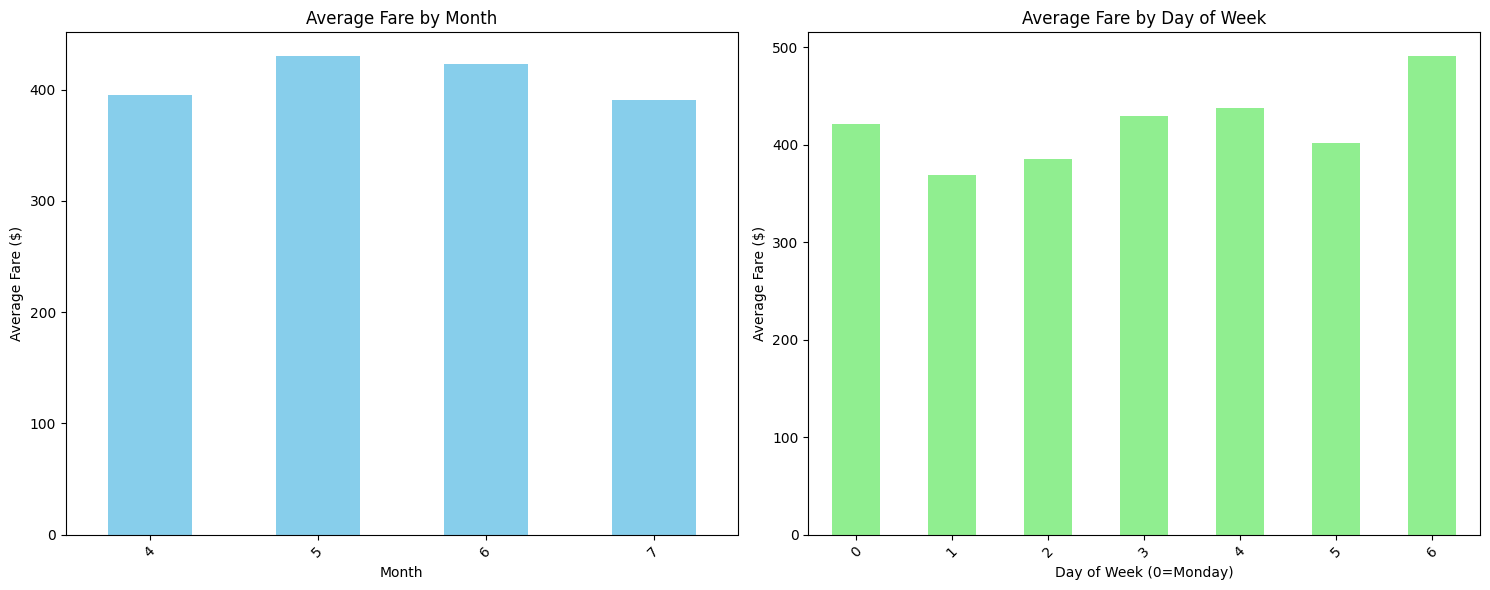

In [49]:
# Run the analysis
results = analyze_fares_by_time(df)

# Print monthly statistics
print("Monthly Fare Analysis:")
print(results['monthly_stats'])

# Print daily statistics
print("\nDaily Fare Analysis:")
print(results['daily_stats'])

**Based on the visualization, we can observe that weekend flight fares are higher. Airlines seem to leverage the holiday period to increase prices, taking advantage of the higher demand**

**travelDuration**

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def analyze_duration_fare(df):
    """
    Analyze relationship between travel duration and fares
    """
    # Calculate correlation
    correlation = df['totalFare'].corr(df['travelDuration']).round(3)
    
    # Create duration bins (in hours)
    df['duration_bin'] = pd.qcut(df['travelDuration'], q=10, labels=['0-10%', '10-20%', '20-30%', '30-40%', 
                                                                    '40-50%', '50-60%', '60-70%', '70-80%', 
                                                                    '80-90%', '90-100%'])
    
    # Calculate average fare for each duration bin
    duration_fare_analysis = df.groupby('duration_bin').agg({
        'totalFare': ['mean', 'count'],
        'travelDuration': 'mean'
    }).round(2)
    
    # Rename columns
    duration_fare_analysis.columns = ['avg_fare', 'flight_count', 'avg_duration']
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    
    # Plot average fare by duration bin
    ax = duration_fare_analysis['avg_fare'].plot(kind='bar', color='skyblue')
    plt.title('Average Fare by Travel Duration')
    plt.xlabel('Duration Percentile')
    plt.ylabel('Average Fare ($)')
    plt.xticks(rotation=45)
    
    # Add value labels on top of each bar
    for i, v in enumerate(duration_fare_analysis['avg_fare']):
        ax.text(i, v, f'${v:,.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Calculate additional metrics
    metrics = {
        'correlation': correlation,
        'fare_per_hour': (df['totalFare'] / df['travelDuration']).mean().round(2),
        'min_duration': df['travelDuration'].min().round(2),
        'max_duration': df['travelDuration'].max().round(2),
        'avg_duration': df['travelDuration'].mean().round(2)
    }
    
    return {
        'duration_fare_stats': duration_fare_analysis,
        'metrics': metrics
    }

Key Metrics:
correlation: 0.311
fare_per_hour: 1.08
min_duration: 46.0
max_duration: 1438.0
avg_duration: 466.55

Detailed Duration-Fare Analysis:
              avg_fare  flight_count  avg_duration
duration_bin                                      
0-10%           270.56         37283        126.51
10-20%          352.13         37129        245.60
20-30%          384.73         36547        320.41
30-40%          420.94         37132        368.45
40-50%          395.94         36898        416.92
50-60%          432.01         37281        470.31
60-70%          443.77         36826        529.79
70-80%          470.15         36880        604.59
80-90%          481.23         36738        700.86
90-100%         539.07         36955        886.68


/tmp/ipykernel_6211/2864491677.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_fare_analysis = df.groupby('duration_bin').agg({


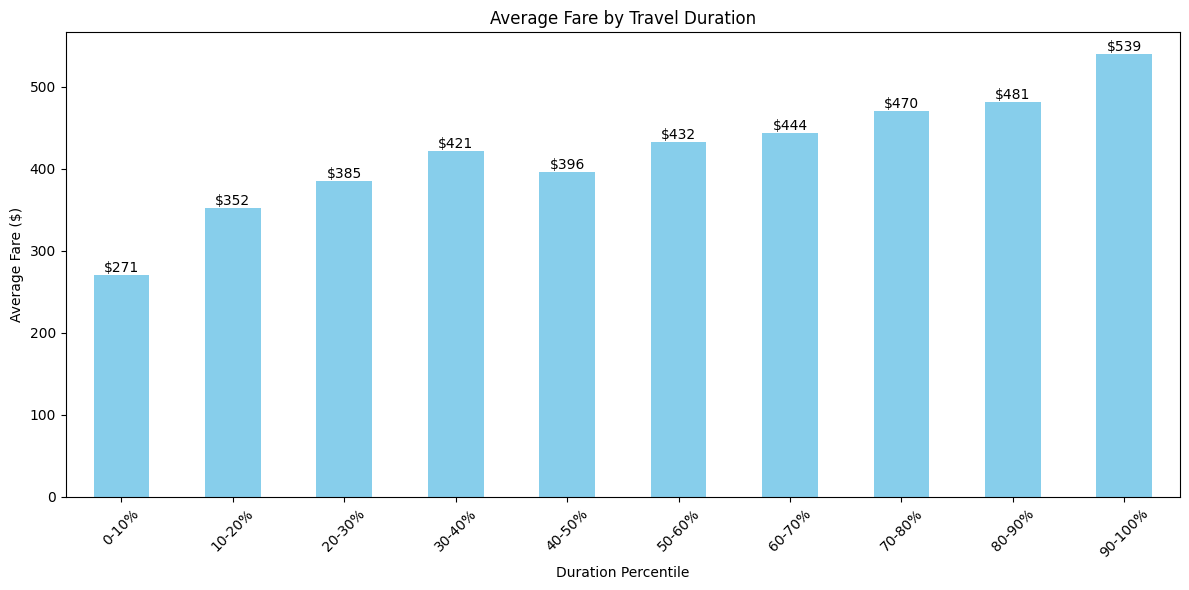

In [51]:
# Run the analysis
results = analyze_duration_fare(df)

# Print correlation and metrics
print("Key Metrics:")
for key, value in results['metrics'].items():
    print(f"{key}: {value}")

# Print detailed stats
print("\nDetailed Duration-Fare Analysis:")
print(results['duration_fare_stats'])

**The bar graph clearly shows and highlights the common pattern that as travel duration increases, the average fare generally rises. The shortest trips (0-10%) have the lowest average fare 271 dollar  while the longest trips 90 to 100%have the highest average fare $539 dollar**

Average Fare by Flight Type:
              count        mean         std    min     25%     50%    75%  \
isNonStop                                                                   
0          312701.0  437.749647  219.266197  50.68  298.61  398.21  528.6   
1           56968.0  315.351475  223.531561  30.69  197.60  263.60  368.6   

              max  
isNonStop          
0          3407.5  
1          3424.6  


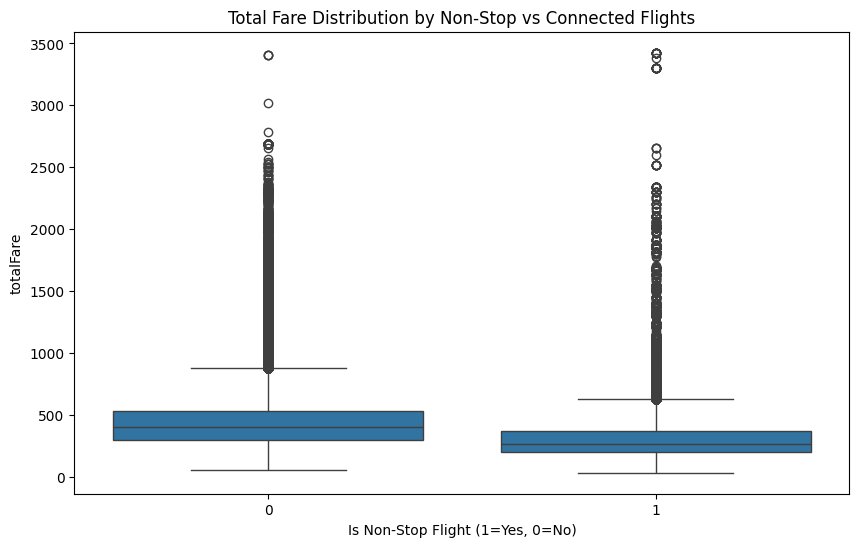


Average Fare by Flight Type:
0: Connected Flight
1: Non-Stop Flight
   isNonStop   totalFare
0          0  437.749647
1          1  315.351475


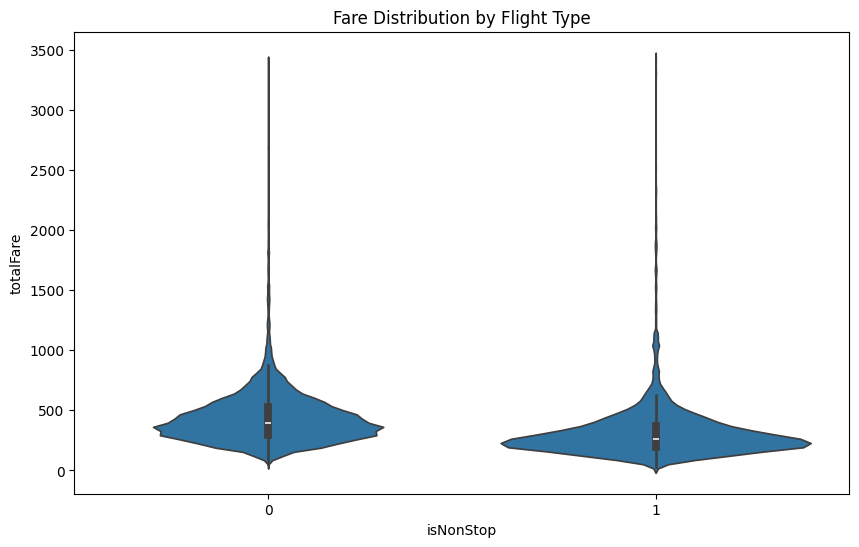


Percentage of flights:
isNonStop
0    84.589457
1    15.410543
Name: proportion, dtype: float64


In [53]:
# Basic statistics by isNonStop
print("Average Fare by Flight Type:")
print(df.groupby('isNonStop')['totalFare'].describe())

# Create a box plot
plt.figure(figsize=(10,6))
sns.boxplot(x='isNonStop', y='totalFare', data=df)
plt.title('Total Fare Distribution by Non-Stop vs Connected Flights')
plt.xlabel('Is Non-Stop Flight (1=Yes, 0=No)')
plt.show()

# Calculate average fares
avg_fare_by_type = df.groupby('isNonStop')['totalFare'].mean().reset_index()
print("\nAverage Fare by Flight Type:")
print("0: Connected Flight")
print("1: Non-Stop Flight")
print(avg_fare_by_type)

# Violin plot to show distribution
plt.figure(figsize=(10,6))
sns.violinplot(x='isNonStop', y='totalFare', data=df)
plt.title('Fare Distribution by Flight Type')
plt.show()

# Calculate the percentage of non-stop vs connected flights
print("\nPercentage of flights:")
print(df['isNonStop'].value_counts(normalize=True) * 100)

Basic Statistics for Days Before Flight:
count    369669.000000
mean         23.463828
std          19.926904
min           1.000000
25%           3.000000
50%          19.000000
75%          42.000000
max          60.000000
Name: date_diff, dtype: float64

Basic Statistics for Total Fare:
count    369669.000000
mean        418.887424
std         224.324569
min          30.690000
25%         276.580000
50%         377.210000
75%         510.100000
max        3424.600000
Name: totalFare, dtype: float64


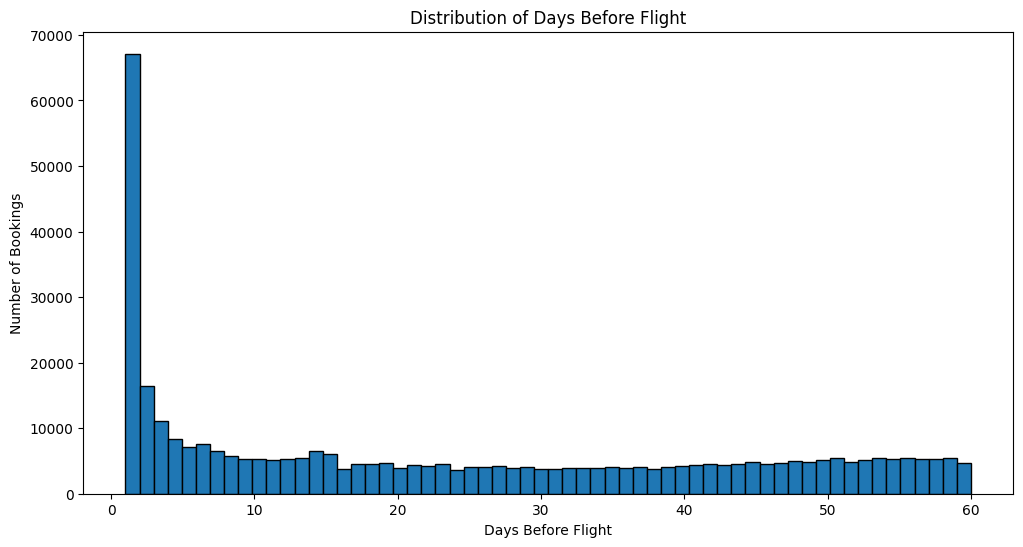

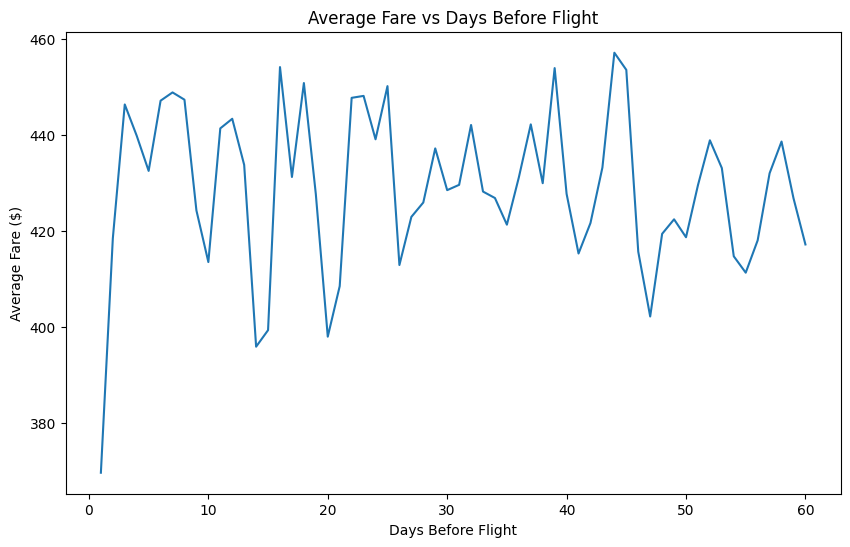


Booking and Fare Pattern Summary:
Most common booking day: 1 days before flight
Number of bookings: 67129
Average fare: $369.57

Least common booking day: 60 days before flight
Number of bookings: 4633
Average fare: $417.20


In [61]:
# Basic statistics for date_diff and fare
print("Basic Statistics for Days Before Flight:")
print(df['date_diff'].describe())
print("\nBasic Statistics for Total Fare:")
print(df['totalFare'].describe())

# Histogram of booking distribution
plt.figure(figsize=(12,6))
plt.hist(df['date_diff'], bins=60, edgecolor='black')
plt.title('Distribution of Days Before Flight')
plt.xlabel('Days Before Flight')
plt.ylabel('Number of Bookings')
plt.show()

# Daily average fares
daily_avg_fares = df.groupby('date_diff')['totalFare'].mean()
plt.figure(figsize=(10,6))
plt.plot(daily_avg_fares.index, daily_avg_fares.values)
plt.title('Average Fare vs Days Before Flight')
plt.xlabel('Days Before Flight')
plt.ylabel('Average Fare ($)')
plt.show()

# Print key statistics about booking patterns and fares
print("\nBooking and Fare Pattern Summary:")
booking_counts = df['date_diff'].value_counts().sort_index()
print(f"Most common booking day: {booking_counts.index[0]} days before flight")
print(f"Number of bookings: {booking_counts.iloc[0]}")
print(f"Average fare: ${df[df['date_diff'] == booking_counts.index[0]]['totalFare'].mean():.2f}")

print(f"\nLeast common booking day: {booking_counts.index[-1]} days before flight")
print(f"Number of bookings: {booking_counts.iloc[-1]}")
print(f"Average fare: ${df[df['date_diff'] == booking_counts.index[-1]]['totalFare'].mean():.2f}")

**This dataset surprisingly shows that last-minute bookings 1 days before are actually the cheapest, at 369. This does not follow the trend belief that last-minute flights are more expensive.**

Basic Statistics for Travel Duration (in hours):
count    369669.000000
mean        466.545301
std         216.723512
min          46.000000
25%         320.000000
50%         442.000000
75%         603.000000
max        1438.000000
Name: travelDuration, dtype: float64


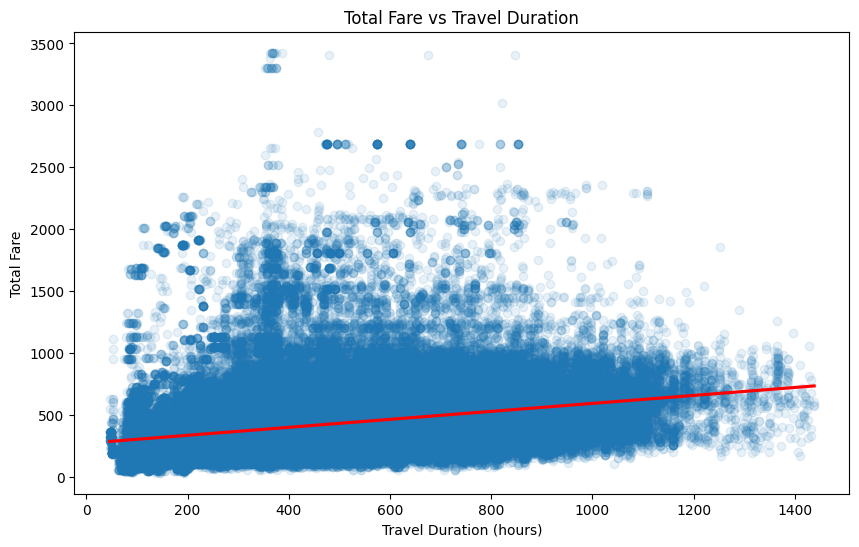


Correlation between travel duration and total fare: 0.311

Average fares by duration quartiles:
Average fare for flights <= 320.00 hours: $325.32
Average fare for flights <= 442.00 hours: $364.68
Average fare for flights <= 603.00 hours: $391.43


In [59]:
# Basic statistics for travelDuration
print("Basic Statistics for Travel Duration (in hours):")
print(df['travelDuration'].describe())

# Create scatter plot with trend line
plt.figure(figsize=(10,6))
sns.regplot(x='travelDuration', y='totalFare', data=df, scatter_kws={'alpha':0.1}, line_kws={'color': 'red'})
plt.title('Total Fare vs Travel Duration')
plt.xlabel('Travel Duration (hours)')
plt.ylabel('Total Fare')
plt.show()

# Calculate correlation
correlation = df['travelDuration'].corr(df['totalFare'])
print(f"\nCorrelation between travel duration and total fare: {correlation:.3f}")

# Calculate average fares for some key statistics
print("\nAverage fares by duration quartiles:")
quartiles = df['travelDuration'].quantile([0.25, 0.5, 0.75])
for q, value in quartiles.items():
    mask = df['travelDuration'] <= value
    avg_fare = df[mask]['totalFare'].mean()
    print(f"Average fare for flights <= {value:.2f} hours: ${avg_fare:.2f}")

**The correlation of 0.311 shows a weak positive relationship between flight duration and fare—as travel time increases, prices tend to increase slightly but not dramatically. The shortest flights tend to have the highest prices, whereas the longest flights have lower prices**

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369671 entries, 1799870 to 2833400
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   legId                              369671 non-null  object        
 1   searchDate                         369671 non-null  datetime64[ns]
 2   flightDate                         369671 non-null  datetime64[ns]
 3   startingAirport                    369671 non-null  object        
 4   destinationAirport                 369671 non-null  object        
 5   travelDuration                     369671 non-null  float64       
 6   isBasicEconomy                     369671 non-null  int64         
 7   isRefundable                       369671 non-null  bool          
 8   isNonStop                          369671 non-null  bool          
 9   totalFare                          369671 non-null  float64       
 10  totalTravelDistanc

In [48]:
# List of features to check
features = [
    'month', 'day', 'hour', 'minute', 'day_of_week', 'week_of_year', 'date_diff',
    'travelDuration', 'isBasicEconomy', 'isRefundable', 'isNonStop',
    'totalTravelDistance', 'totalFare',  # Numerical features
    'startingAirport', 'destinationAirport',  # Categorical features
    'cabin_Leg1', 'cabin_Leg2', 'cabin_Leg3', 'cabin_Leg4'
   
]

# Check for missing values
missing_values = df[features].isnull().sum()
print("Missing values in important features:")
print(missing_values[missing_values > 0])


Missing values in important features:
Series([], dtype: int64)


In [49]:
df.head().T

,1799870,221338,221326,221327,221328
legId,230072de9338321ca5b68308a5010902,49045917b782a566f75e5323ba5e85ee,469a9a46f134f53c298a46be94696845,685fdabb3b9e0a0cea8f1042c7a21240,c0b4a39823641254f5c05cc6704d39ce
searchDate,2022-05-19 00:00:00,2022-05-19 00:00:00,2022-05-19 00:00:00,2022-05-19 00:00:00,2022-05-19 00:00:00
flightDate,2022-05-23 00:00:00,2022-05-28 00:00:00,2022-05-27 00:00:00,2022-05-27 00:00:00,2022-05-28 00:00:00
startingAirport,EWR,DFW,DFW,DFW,DFW
destinationAirport,SFO,ATL,SFO,SFO,ATL
travelDuration,637.0,127.0,475.0,332.0,403.0
isBasicEconomy,0,0,0,0,0
isRefundable,False,False,False,False,False
isNonStop,False,True,False,False,False
totalFare,667.6,202.6,704.6,721.6,122.98


In [50]:
df['isRefundable'] = df['isRefundable'].astype(int)
df['isNonStop'] = df['isNonStop'].astype(int)

In [51]:
# List of columns to drop
columns_to_drop = [
    'legId',
    'searchDate',
    'flightDate',
    'segmentsDepartureTimeEpochSeconds',
    'segmentsDepartureTimeRaw',
    'segmentsArrivalTimeEpochSeconds',
    'segmentsArrivalTimeRaw',
    'segmentsArrivalAirportCode',
    'segmentsDepartureAirportCode',
    'segmentsAirlineName',
    'segmentsAirlineCode',
    'segmentsDurationInSeconds',
    'segmentsDistance',  
    'segmentsCabinCode'
]

# Drop the columns
df_processed = df.drop(columns=columns_to_drop)


In [52]:
# Check the columns of the processed DataFrame
print("Columns in the processed DataFrame:")
print(df_processed.columns.tolist())


Columns in the processed DataFrame:
['startingAirport', 'destinationAirport', 'travelDuration', 'isBasicEconomy', 'isRefundable', 'isNonStop', 'totalFare', 'totalTravelDistance', 'month', 'day', 'day_of_week', 'week_of_year', 'date_diff', 'hour', 'minute', 'cabin_Leg1', 'cabin_Leg2', 'cabin_Leg3', 'cabin_Leg4']


In [53]:
if df['isNonStop'].dtype == 'bool':
    df['isNonStop'] = df['isNonStop'].astype(int)


In [54]:
print(df['isNonStop'].unique())


[0 1]


In [55]:
# Save the processed DataFrame to 'processed.csv'
df_processed.to_csv('processed.csv', index=False)


In [7]:
import pandas as pd

df = pd.read_csv('../data/processed/processed.csv')

In [9]:
df.shape

(369671, 19)

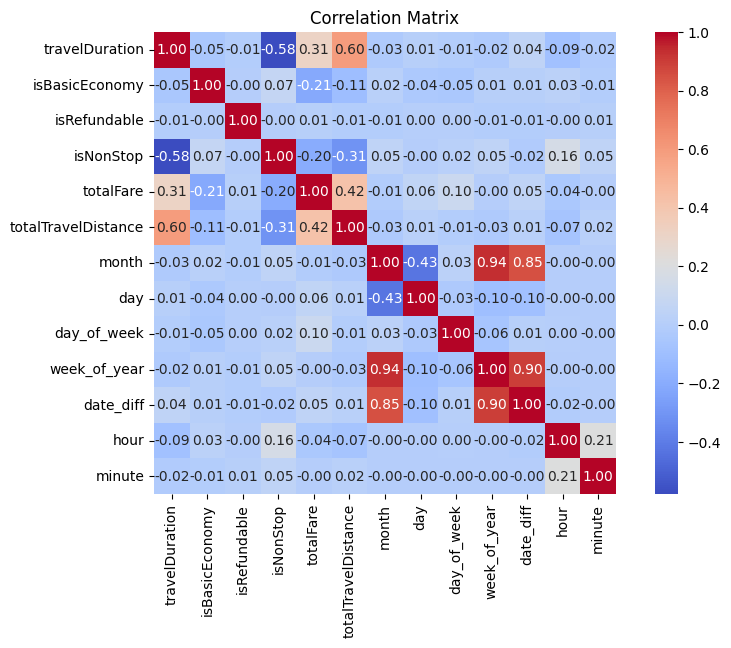

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numerical columns for correlation
numerical_columns = [
    'travelDuration', 'isBasicEconomy', 'isRefundable', 'isNonStop', 
    'totalFare', 'totalTravelDistance', 'month', 'day', 'day_of_week', 
    'week_of_year', 'date_diff', 'hour', 'minute'
]

# Calculate the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

In [3]:
df.head()

,startingAirport,destinationAirport,travelDuration,isBasicEconomy,isRefundable,isNonStop,totalFare,totalTravelDistance,month,day,day_of_week,week_of_year,date_diff,hour,minute,cabin_Leg1,cabin_Leg2,cabin_Leg3,cabin_Leg4
0,EWR,SFO,637.0,0,0,0,667.60,2848.0,5,23,0,21,4,8,15,coach,coach,no_stop,no_stop
1,DFW,ATL,127.0,0,0,1,202.60,725.0,5,28,5,21,9,14,25,coach,no_stop,no_stop,no_stop
2,DFW,SFO,475.0,0,0,0,704.60,2342.0,5,27,4,21,8,6,15,coach,coach,no_stop,no_stop
3,DFW,SFO,332.0,0,0,0,721.60,1604.0,5,27,4,21,8,11,40,coach,coach,no_stop,no_stop
4,DFW,ATL,403.0,0,0,0,122.98,1857.0,5,28,5,21,9,22,7,coach,coach,no_stop,no_stop


#### Saving the Totaltraveldistance and medianTravelDistance for future analysis

In [ ]:
# Group by starting and destination airports to compute both median travel distance and duration
travel_stats = df.groupby(['startingAirport', 'destinationAirport']).agg({
    'totalTravelDistance': 'median',
    'travelDuration': 'median'
}).reset_index()

# Rename columns for clarity
travel_stats.rename(columns={
    'totalTravelDistance': 'medianTravelDistance',
    'travelDuration': 'medianTravelDuration'
}, inplace=True)

# Save to CSV
travel_stats.to_csv('median_travel_distances.csv', index=False)

In [57]:
from sklearn.model_selection import train_test_split

# Split into 80% training and 20% remaining data
train_data, remaining_data = train_test_split(
    df, test_size=0.2, random_state=42
)


In [58]:
# Split remaining data into 50% validation and 50% test after the train split 
val_data, test_data = train_test_split(
    remaining_data, test_size=0.5, random_state=42
)


In [59]:
total_length = len(df)
train_length = len(train_data)
val_length = len(val_data)
test_length = len(test_data)

print(f"Total dataset size: {total_length}")
print(f"Training set size: {train_length} ({train_length / total_length * 100:.2f}%)")
print(f"Validation set size: {val_length} ({val_length / total_length * 100:.2f}%)")
print(f"Test set size: {test_length} ({test_length / total_length * 100:.2f}%)")


Total dataset size: 369671
Training set size: 295736 (80.00%)
Validation set size: 36967 (10.00%)
Test set size: 36968 (10.00%)


In [60]:
# Save training data
train_data.to_csv('train_data.csv', index=False)

# Save validation data
val_data.to_csv('val_data.csv', index=False)

# Save test data
test_data.to_csv('test_data.csv', index=False)
